# Hodgkin-Huxleyモデル

Juliaで[Hodgkin-Huxleyモデル](https://www.izhikevich.org/publications/spikes.htm)の実装をする。JuliaによるSNNの実装は[SpikingNeuralNetworks.jl](https://github.com/AStupidBear/SpikingNeuralNetworks.jl)が既にある。この記事の実装ではJuliaの書き方を勉強すべく大幅に参考にした。以下はJulia 1.4.0で実行。

## モデルの定義
まず必要なパッケージを読み込む。

In [1]:
using Plots
using Base: @kwdef
using Parameters: @unpack # or using UnPack

変更しない定数を保持する`struct`の`HHParameter`と、変数を保持する`mutable struct`の`HH`を作成する。`v, m, h, n` はHH modelの4変数だが、`r`はpre-synaptic dynamicsを表す変数。詳細は後述。

In [2]:
@kwdef struct HHParameter{FT}
    Cm::FT = 1.0 # 膜容量(uF/cm^2)
    gNa::FT = 120.0 # Na+ の最大コンダクタンス(mS/cm^2)
    gK::FT = 36.0 # K+ の最大コンダクタンス(mS/cm^2)
    gL::FT = 0.3 # 漏れイオンの最大コンダクタンス(mS/cm^2)
    ENa::FT = 50.0 # Na+ の平衡電位(mV)
    EK::FT = -77.0 # K+ の平衡電位(mV)
    EL::FT = -54.387 #漏れイオンの平衡電位(mV)
    tr::FT = 0.5 # ms
    td::FT = 8.0 # ms
    invtr::FT = 1.0 / tr
    invtd::FT = 1.0 / td
    v0::FT = -20.0 # mV
end

@kwdef mutable struct HH{FT}
    param::HHParameter = HHParameter{FT}()
    N::Int32
    v::Vector{FT} = fill(-65.0, N)
    m::Vector{FT} = fill(0.05, N)
    h::Vector{FT} = fill(0.6, N)
    n::Vector{FT} = fill(0.32, N)
    r::Vector{FT} = zeros(N)
end

## 変数の更新式
次に変数を更新する関数`updateHH!`を書く。solverとしてRK4などの選択ができればよかったが、SNNに使う予定なのでEuler法で離散化。

In [3]:
function updateHH!(variable::HH, param::HHParameter, I::Vector, dt)
    @unpack N, v, m, h, n, r = variable
    @unpack Cm, gNa, gK, gL, ENa, EK, EL, tr, td, invtr, invtd, v0= param
    @inbounds for i = 1:N
        m[i] += dt * ((0.1(v[i]+40.0)/(1.0 - exp(-0.1(v[i]+40.0))))*(1.0 - m[i]) - 4.0exp(-(v[i]+65.0) / 18.0)*m[i])
        h[i] += dt * ((0.07exp(-0.05(v[i]+65.0)))*(1.0 - h[i]) - 1.0/(1.0 + exp(-0.1(v[i]+35.0)))*h[i])
        n[i] += dt * ((0.01(v[i]+55.0)/(1.0 - exp(-0.1(v[i]+55.0))))*(1.0 - n[i]) - (0.125exp(-0.0125(v[i]+65)))*n[i])
        v[i] += dt / Cm * (I[i] - gNa * m[i]^3 * h[i] * (v[i] - ENa) - gK * n[i]^4 * (v[i] - EK) - gL * (v[i] - EL))
        r[i] += dt * ((invtr - invtd) * (1.0 - r[i])/(1.0 + exp(-v[i] + v0)) - r[i] * invtd)
    end
end

updateHH! (generic function with 1 method)

forループを用いて1つのニューロンごとにパラメータを更新する。

## シミュレーションの実行
いくつかの定数を設定してシミュレーションを実行する。

In [4]:
T = 450 # ms
dt = 0.01f0 # ms
nt = Int32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(10f0 * ((t .> 50) - (t .> 200)) + 35f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# 記録用
varr = zeros(Float32, nt, N)
rarr = zeros(Float32, nt, N)

# modelの定義
neurons = HH{Float32}(N=N)

# simulation
@time for i = 1:nt
    updateHH!(neurons, neurons.param, I[i, :], dt)
    varr[i, :] = neurons.v
    rarr[i, :] = neurons.r
end

  0.174853 seconds (1.00 M allocations: 35.117 MiB, 4.19% gc time)


ニューロンの膜電位 `v`、presynaptic dynamics `r`, 刺激電流 `I`の描画をする。

In [5]:
p1 = plot(t, varr[:, 1])
p2 = plot(t, rarr[:, 1])
p3 = plot(t, I[:, 1])
plot(p1, p2, p3, 
    xlabel = ["" "" "Times (ms)"], 
    ylabel= ["Membrane\n potential (mV)" "Pre-synaptic\n dynamics" "Injection\n current (nA)"],
    layout = grid(3, 1, heights=[0.5, 0.25, 0.25]), legend = false)

## HH networkにおけるsynaptic dynamicsについて
$r_{j}$を$j$番目のニューロンのpre-synaptic dynamicsとすると、$r_{j}$は次式に従う。

$$
\frac{\mathrm{d} r_{j}}{\mathrm{d} t}=\left(\frac{1}{\tau_{r}}-\frac{1}{\tau_{d}}\right) \frac{1-r_{j}}{1+\exp \left(-V_{j}+V_{0}\right)}-\frac{r_{j}}{\tau_{d}}
$$

ただし、時定数 $\tau_r=0.5, \tau_d = 8$ (ms), 反転電位 $V_0 = -20$ (mV)とする。前節で既に$r$の描画は行ったが、パルス波を印加した場合の挙動を確認する。

In [6]:
T = 50 # ms
dt = 0.01f0 # ms
nt = Int32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(5f0 * ((t .> 10) - (t .> 15)), 1, N)  # injection current

# 記録用
varr = zeros(Float32, nt, N)
rarr = zeros(Float32, nt, N)

# modelの定義
neurons = HH{Float32}(N=N)

# simulation
@time for i = 1:nt
    updateHH!(neurons, neurons.param, I[i, :], dt)
    varr[i, :] = neurons.v
    rarr[i, :] = neurons.r
end

  0.006842 seconds (60.91 k allocations: 1.387 MiB)


描画してみる。

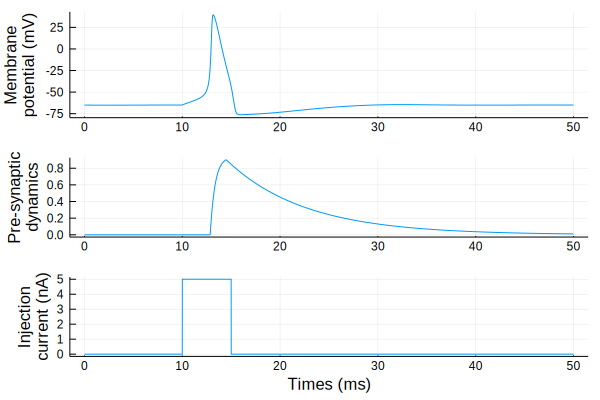

In [7]:
p1 = plot(t, varr[:, 1])
p2 = plot(t, rarr[:, 1])
p3 = plot(t, I[:, 1])
plot(p1, p2, p3, 
    xlabel = ["" "" "Times (ms)"], 
    ylabel= ["Membrane\n potential (mV)" "Pre-synaptic\n dynamics" "Injection\n current (nA)"],
    layout = grid(3, 1, heights=[0.4, 0.3, 0.3]), legend = false)